In [1]:
from bitcoin import Bitcoin
import model
import sm
import mdp

In [2]:
protocol = Bitcoin()
alpha = 0.25
gamma = 0.25

# implicit SM model
# careful: this truncates the common chain; that mechanism is easy to define for Bitcoin but might cause headaches for other protocols
# take in mind that the (absence of) truncation might affect the rest of the algorithm
base_model = sm.SelfishMining(protocol, alpha=alpha, gamma=gamma, maximum_size=1000000)

terminal_state = b""
horizon = 100

# implicit SM model with PTO applied on the fly
pto_model = model.PTO_wrapper(
    base_model, horizon=horizon, terminal_state=terminal_state
)

# Level 0: explore honest policy, derive MC, evaluate

#### L0.1: explore states and build MC 

In [3]:
# This will probably not terminate when we remove truncation!
def explore_policy(m, policy):
    states = dict()
    queue = set()

    for s, p in m.start():
        queue.add(s)

    while len(queue) > 0:
        s = queue.pop()

        assert s not in states
        states[s] = []

        a = policy(s)
        for t in m.apply(a, s):
            if t.probability == 0:
                continue

            states[s].append((t.state, t.probability, t.reward, t.progress))

            if t.state in states or t.state == terminal_state:
                continue
            else:
                queue.add(t.state)

    states[terminal_state] = []  # no transitions available in terminal_state

    return m.start(), states


def explore_honest(m):
    return explore_policy(m, m.honest)


def with_int_states(mc):
    start, tx = mc
    table = {s: i for i, s in enumerate(tx.keys())}
    istart = []
    for s0, p in start:
        istart.append((table[s0], p))
    istart = sorted(istart)
    itx = []
    for s0, tx_lst in tx.items():
        itx.append([(table[s1], prb, rew, prg) for s1, prb, rew, prg in tx_lst])
    return istart, itx


mc = explore_honest(base_model)
with_int_states(mc)

([(0, 0.25), (2, 0.75)],
 [[(1, 0.0625, 0.0, 0),
   (7, 0.1875, 0.0, 0),
   (1, 0.1875, 0.0, 0),
   (7, 0.5625, 0.0, 0)],
  [(5, 1, 0.0, 0)],
  [(3, 0.0625, 0.0, 0),
   (6, 0.1875, 0.0, 0),
   (3, 0.1875, 0.0, 0),
   (6, 0.5625, 0.0, 0)],
  [(4, 1, 0.0, 0)],
  [(1, 0.0625, 1.0, 1),
   (7, 0.1875, 1.0, 1),
   (1, 0.1875, 1.0, 1),
   (7, 0.5625, 1.0, 1)],
  [(1, 0.0625, 1.0, 1),
   (7, 0.1875, 1.0, 1),
   (1, 0.1875, 1.0, 1),
   (7, 0.5625, 1.0, 1)],
  [(9, 1, 0.0, 0)],
  [(8, 1, 0.0, 0)],
  [(3, 0.0625, 0.0, 1),
   (6, 0.1875, 0.0, 1),
   (3, 0.1875, 0.0, 1),
   (6, 0.5625, 0.0, 1)],
  [(3, 0.0625, 0.0, 1),
   (6, 0.1875, 0.0, 1),
   (3, 0.1875, 0.0, 1),
   (6, 0.5625, 0.0, 1)],
  []])

#### L0.2: evaluate MC; RTDP style

- random walk through the MC
- back-propagate values

This should converge quickly initially as is focuses on important states.
For the same reason it will slow down when getting closer to the true limits.

In [4]:
import random


def sample_next_state_and_map(tx_lst, fun):
    x = random.random()
    i = None
    acc_prb = 0.0
    ret = []
    for j, tx in enumerate(tx_lst):
        ret.append(fun(tx))
        if acc_prb <= x:
            i = j
        acc_prb += tx[1]
    next_state = tx_lst[i][0]
    return next_state, ret


def mc_path_backpropagation_eval(m, policy):
    start, tx = with_int_states(explore_policy(m, policy))

    count = [0] * len(tx)
    value = [0.0] * len(tx)
    prg_v = [0.0] * len(tx)
    state, _ = sample_next_state_and_map(start, lambda x: None)
    terminating = False

    n_steps = 100000
    for i in range(n_steps):
        if len(tx[state]) < 1:  # terminal state
            terminating = True
            state, _ = sample_next_state_and_map(start, lambda x: None)

        def fun(t):
            next_state, prb, rew, prg = t
            return prb * (rew + value[next_state]), prb * (prg + prg_v[next_state])

        next_state, values_and_prg_vs = sample_next_state_and_map(tx[state], fun)
        values, prg_vs = zip(*values_and_prg_vs)
        value[state] = sum(values)
        prg_v[state] = sum(prg_vs)
        count[next_state] += 1
        state = next_state

    # start state estimate
    start_value_estimate = sum([value[s] * p for s, p in start])
    start_prg_v_estimate = sum([prg_v[s] * p for s, p in start])

    if terminating:
        return start_value_estimate, start_prg_v_estimate, value, prg_v

    else:
        # steady state estimate
        # note: steady state don't make sense for PTO; the terminal state is the steady state!
        assert sum(count) == n_steps
        steady_state = [c / n_steps for c in count]
        steady_state_value = sum([v * c for v, c in zip(value, count)]) / n_steps
        steady_state_prg_v = sum([v * c for v, c in zip(prg_v, count)]) / n_steps

        return (
            start_value_estimate,
            start_prg_v_estimate,
            value,
            prg_v,
            steady_state,
            steady_state_value,
            steady_state_prg_v,
        )

In [5]:
expected_reward, expected_progress, _, _ = mc_path_backpropagation_eval(
    pto_model, pto_model.honest
)
assert abs(expected_progress - horizon) < 0.00001
expected_reward / expected_progress, alpha

(0.24999999999999736, 0.25)

In [6]:
_, _, _, _, _, expected_reward, expected_progress = mc_path_backpropagation_eval(
    base_model, base_model.honest
)
expected_reward / expected_progress, alpha

(0.24999189198911073, 0.25)

# Level 1: explore MDP around honest policy

In [7]:
# This will probably not terminate when we remove common chain truncation in the selfish mining model!


def explore_around_policy(m, policy, max_distance=0):
    states = (
        dict()
    )  # state -> action -> list of transitions (next state, probability, reward, progress, ...)
    queue = set()  # states to be explored
    distances = dict()  # state -> distance to honest policy

    def distance(s):
        return distances.get(s, float("inf"))

    for s, p in m.start():
        queue.add(s)
        distances[s] = 0

    while len(queue) > 0:
        s = queue.pop()
        d = distances[s]

        assert s not in states
        states[s] = dict()

        h = policy(s)
        for a in m.actions(s):
            states[s][a] = []
            for t in m.apply(a, s):
                if t.probability == 0:
                    continue

                states[s][a].append(t)

                if a == h:
                    distances[t.state] = min(distance(t.state), distances[s])
                else:
                    distances[t.state] = min(distance(t.state), distances[s] + 1)
                # I'm not sure about this mechanism
                # What if we find a new path to a state with smaller distance than known before?
                # What's the distance of state that can be reached with honest policy but only from a state with disctance > 0?
                # I guess the right approach is incremental exploration: explore distance = 0; then = 1, and so on.
                #
                # Edit: This approach is certainly wrong. The resulting mdp size is not deterministic! It's fixed in the
                # Explorer class below.

                if distances[t.state] > max_distance:
                    continue

                if t.state in states or t.state == terminal_state:
                    continue
                else:
                    queue.add(t.state)

    states[terminal_state] = []  # no transitions available in terminal_state

    return m.start(), states


start, m = explore_around_policy(pto_model, pto_model.honest, max_distance=3)
len(m)

258

In [8]:
# implementing the above loop as incremental exploration

from copy import deepcopy


# Invariant:
# - policy-defined actions are explored first
# - in the result MDP: policy = lambda s: 0
# - states are enumerated in order of exploration
# - states far off the policy have higher state ids than state closer or on the policy
# - policies for smaller MDPs are compatible with policies for bigger MDPs
class Explorer:
    def __init__(self, model, policy):
        self.model = model
        self.policy = policy

        self._mdp = mdp.MDP()
        self.states = []  # state id int -> state
        self.policy_tab = []  # state id int -> action

        self._state_id = dict()  # state -> state id int; see self.state_id()
        self.explored_upto = -1  # state id int; policy action has been explored
        self.fully_explored_upto = -1  # state id int; all actions have been explored

        for s, p in self.model.start():
            self._mdp.start[self.state_id(s)] = p

    def state_id(self, state):
        if state in self._state_id:
            return self._state_id[state]
        else:
            i = len(self._state_id)
            self._state_id[state] = i
            self.states.append(state)
            return i

    @property
    def n_states(self):
        return len(self._state_id)

    @property
    def max_state_id(self):
        return len(self._state_id) - 1

    def explore_along_policy(self):
        while self.max_state_id > self.explored_upto:
            self.explored_upto += 1
            s_id = self.explored_upto
            s = self.states[s_id]

            assert (
                len(self.policy_tab) == s_id
            ), f"logic error, {len(self.policy_tab)} == {s_id}"

            if len(self.model.actions(s)) == 0:
                # s is a terminal state
                self.policy_tab.append(-1)  # policy is not defined, put placeholder
                continue

            a = self.policy(s)
            self.policy_tab.append(a)

            for t in self.model.apply(a, s):
                if t.probability == 0:
                    continue

                t = mdp.Transition(
                    probability=t.probability,
                    destination=self.state_id(t.state),
                    reward=t.reward,
                    progress=t.progress,
                    effect=t.effect,
                )
                self._mdp.add_transition(src=s_id, act=0, t=t)

            self.explored_upto = s_id

    def explore_aside_policy(self):
        self.explore_along_policy()
        assert self.explored_upto == self.max_state_id

        while self.fully_explored_upto < self.explored_upto:
            self.fully_explored_upto += 1
            s_id = self.fully_explored_upto
            s = self.states[s_id]

            a_idx = 0  # policy action has a_idx = 0
            for a in self.model.actions(s):
                if a == self.policy_tab[s_id]:
                    # policy action; already explored
                    continue

                a_idx += 1

                for t in self.model.apply(a, s):
                    if t.probability == 0:
                        continue

                    t = mdp.Transition(
                        probability=t.probability,
                        destination=self.state_id(t.state),
                        reward=t.reward,
                        progress=t.progress,
                        effect=t.effect,
                    )
                    self._mdp.add_transition(src=s_id, act=a_idx, t=t)

    def mdp(self):
        # Note 1. For some states in self.partial_mdp; we've only explored the honest action.
        # That's okay, it forces the attacker to abort the attack.
        # Note 2. Some states are reachable but not yet explored; we have to fix this before
        # returning the MDP.
        self.explore_along_policy()
        assert self.explored_upto == self.max_state_id

        self._mdp.check()

        return deepcopy(self._mdp)


e = Explorer(pto_model, pto_model.honest)
d = 0
m = e.mdp()
ms = [m]
n = m.n_states
print(d, n)
for i in range(5):
    e.explore_aside_policy()
    d += 1
    m = e.mdp()
    ms.append(m)
    prev_n = n
    n = m.n_states
    print(d, n, n / prev_n)

0 11
1 37 3.3636363636363638
2 111 3.0
3 279 2.5135135135135136
4 601 2.154121863799283
5 1166 1.940099833610649


# Level 2: optimize the MDPs

In [ ]:
def evaluate(m, m_honest):
    res = m.value_iteration(stop_delta=0.00001)
    res["episode_reward"] = sum(res["vi_value"][s] * p for s, p in m.start.items())
    res["episode_progress"] = sum(res["vi_progress"][s] * p for s, p in m.start.items())
    res["reward_per_progress"] = res["episode_reward"] / res["episode_progress"]

    res["fully_honest"] = all(a < 1 for a in res["vi_policy"])
    # It at first came unexpeted to me, that vi_policy has dishonest entries while the honest policy was optimal.
    # Turns out the dishonest behavior happens on states that cannot be reached from the honest policy.
    # I'm now comparing the policies for only these states which can be rewach from the honest policy.
    # If the agent acts honest on these states it acts honest everywhere.
    res["honest"] = all(a < 1 for a in res["vi_policy"][: m_honest.n_states])
    return res


for d, m in enumerate(ms):
    res = evaluate(m, ms[0])
    print(
        d,
        m.n_states,
        res["fully_honest"],
        res["honest"],
        res["episode_progress"],
        res["reward_per_progress"],
    )

# Level 3: Find break-even points

In [22]:
evaluations = dict()
break_even = dict()

In [45]:
gamma = 0.0
distance = 5
precision = 12


def localize_be(gamma, distance, precision):
    upper_alpha = 1
    lower_alpha = 0
    for i in range(precision):
        alpha = (upper_alpha + lower_alpha) / 2
        base_model = sm.SelfishMining(
            protocol, alpha=alpha, gamma=gamma, maximum_size=1000000
        )
        pto_model = model.PTO_wrapper(
            base_model, horizon=horizon, terminal_state=terminal_state
        )

        attack_found = False
        e = Explorer(pto_model, pto_model.honest)
        m_honest = e.mdp()
        for d in range(1, distance + 1):
            e.explore_aside_policy()  # increase distance by one
            m = e.mdp()

        res = evaluate(m, m_honest)
        evaluations[(gamma, distance, alpha)] = res
        if res["honest"]:
            print(f"no attack for alpha={alpha}")
        else:
            rpp = res["reward_per_progress"]
            print(f"   attack for alpha={alpha} w/ rpp={rpp}")
            attack_found = True

        if attack_found:
            upper_alpha = alpha
        else:
            lower_alpha = alpha

    break_even[(gamma, distance)] = upper_alpha


for gamma in [0, 0.25, 0.5, 0.75, 1]:
    for distance in range(1, 6):
        print(f"gamma = {gamma}, distance = {distance}")
        localize_be(gamma, distance, precision)

gamma = 0, distance = 1
no attack for alpha=0.5
   attack for alpha=0.75 w/ rpp=0.8538412396784669
   attack for alpha=0.625 w/ rpp=0.692499622602182
   attack for alpha=0.5625 w/ rpp=0.5982537254499815
   attack for alpha=0.53125 w/ rpp=0.5492005527112394
   attack for alpha=0.515625 w/ rpp=0.524397590249471
   attack for alpha=0.5078125 w/ rpp=0.5119540841505253
   attack for alpha=0.50390625 w/ rpp=0.5057254891452536
   attack for alpha=0.501953125 w/ rpp=0.502610304950212
   attack for alpha=0.5009765625 w/ rpp=0.5010533669691105
   attack for alpha=0.50048828125 w/ rpp=0.5002766835536994
   attack for alpha=0.500244140625 w/ rpp=0.4998920505373576
gamma = 0, distance = 2
   attack for alpha=0.5 w/ rpp=0.5526505013144368
no attack for alpha=0.25
no attack for alpha=0.375
   attack for alpha=0.4375 w/ rpp=0.45793663925195627
   attack for alpha=0.40625 w/ rpp=0.4100193429350442
no attack for alpha=0.390625
   attack for alpha=0.3984375 w/ rpp=0.3980694910329672
no attack for alpha=0

In [32]:
for (gamma, distance, alpha), res in evaluations.items():
    if (gamma, distance) not in break_even:
        break_even[(gamma, distance)] = 1.0

    if not res["honest"]:
        break_even[(gamma, distance)] = min(break_even[(gamma, distance)], alpha)

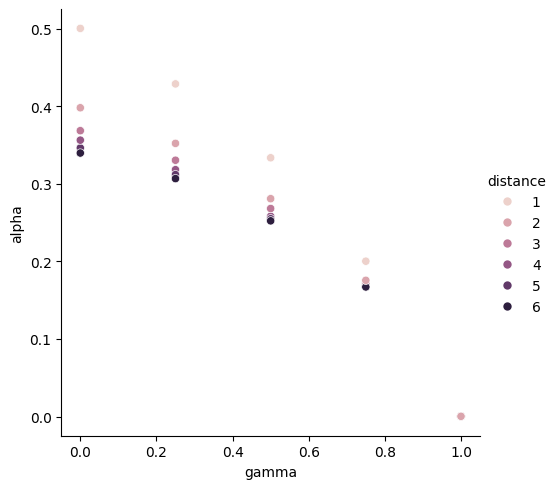

In [57]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame(
    [(distance, gamma, be) for (gamma, distance), be in break_even.items()],
    columns=["distance", "gamma", "alpha"],
)
sns.relplot(data=df, x="gamma", y="alpha", hue="distance")